# Boosting Models

In the last notebook, I tried the Naive Bayes model and found that Count Vectorizer and all text column work better for the Naive Bayes models. Scores were good, but I want to try boosting models to add them to the stacking model with Naive Bayes.

---

In [1]:
# Imports
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier

# Import my custom functions for fitting and scoring models, tokenizing, and plotting residuals.
import functions_for_modeling

In [2]:
# Read the data
reddit = pd.read_csv('../data/reddit_cleaned_removed_words.csv')

In [3]:
# Split the data
X = reddit['all_text']
y = reddit['subreddit_num']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 18,  stratify = y)

## XGBClassifier

In [7]:
# XGBClassifier with Count Vectorizer adapted from (https://towardsdatascience.com/beginners-guide-to-xgboost-for-classification-problems-50f75aac5390)
pipe_xgb = Pipeline([
    ('cvec', CountVectorizer()),
    ('xgb', XGBClassifier())
])

pipe_params_xgb = {
    'cvec__max_features': range(1000, 7000, 1000),
    'cvec__min_df': range(1, 7),
    'cvec__max_df': [0.8, 0.9, 0.95],
    'cvec__stop_words': [None, 'english'],
    'xgb__learning_rate': np.linspace(0.02, 0.2, 10),
    'xgb__gamma': np.linspace(0.1, 0.3, 10),
    'xgb__reg_alpha': [0.4, 0.5, 0.6],
    'xgb__max_depth': range(1, 9),
    'xgb__subsample': [0.8, 0.9, 0.95],
    'xgb__colsample_bytree': np.linspace(0.6, 1, 10)  
    
}

kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=18)

rs_xgb = RandomizedSearchCV(pipe_xgb, 
                       param_distributions = pipe_params_xgb,
                       n_jobs = -1,
                       cv = kfold, 
                       random_state=18,
                       n_iter=40)

In [28]:
rs_xbg = functions_for_modeling.model_fit_scores(rs_xgb, X_train, y_train, X_test, y_test)

Cross Validation Score: 0.8450909314327845
Best Parameters: {'xgb__subsample': 0.9, 'xgb__reg_alpha': 0.4, 'xgb__max_depth': 5, 'xgb__learning_rate': 0.14, 'xgb__gamma': 0.2777777777777778, 'xgb__colsample_bytree': 0.7333333333333333, 'cvec__stop_words': 'english', 'cvec__min_df': 3, 'cvec__max_features': 3000, 'cvec__max_df': 0.95}
Train accuracy: 0.91101152368758
Test accuracy: 0.8637236084452975
F1 score: 0.7526132404181184


This model has lower scores than my best Naive Bayes model, especially the F1 score is much lower and it still overfits. I will try TFidF Vectorizer and Tokenizers to improve the scores.

In [29]:
# XGBClassifier with Tfidf Vectorizer
pipe_xgb_tf = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('xgb', XGBClassifier())
])

pipe_params_xgb_tf = {
    'tfidf__max_features': range(1000, 7000, 1000),
    'tfidf__stop_words': [None, 'english'],
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'tfidf__min_df': range(1, 7),
    'tfidf__max_df': [0.8, 0.9, 0.95],
    'xgb__learning_rate': np.linspace(0.02, 0.2, 10),
    'xgb__gamma': np.linspace(0.1, 0.3, 10),
    'xgb__reg_alpha': [0.4, 0.5, 0.6],
    'xgb__max_depth': range(1, 9),
    'xgb__subsample': [0.8, 0.9, 0.95],
    'xgb__colsample_bytree': np.linspace(0.6, 1, 10)  
    
}


rs_xgb_tf = RandomizedSearchCV(pipe_xgb_tf, 
                       param_distributions = pipe_params_xgb_tf,
                       n_jobs = -1,
                       cv = kfold, 
                       random_state=18,
                       n_iter=40)

In [30]:
rs_xgb_tf = functions_for_modeling.model_fit_scores(rs_xgb_tf, X_train, y_train, X_test, y_test)

Cross Validation Score: 0.835471450806914
Best Parameters: {'xgb__subsample': 0.9, 'xgb__reg_alpha': 0.5, 'xgb__max_depth': 5, 'xgb__learning_rate': 0.14, 'xgb__gamma': 0.1, 'xgb__colsample_bytree': 0.7333333333333333, 'tfidf__stop_words': 'english', 'tfidf__ngram_range': (1, 1), 'tfidf__min_df': 4, 'tfidf__max_features': 2000, 'tfidf__max_df': 0.95}
Train accuracy: 0.9206145966709347
Test accuracy: 0.8464491362763915
F1 score: 0.7163120567375888


This model scores very close, but a bit lower than with Count Vectorizer

### XGBoost with Tokenizers

In [5]:
t_stem_xgb = functions_for_modeling.model_tokenazer(XGBClassifier(subsample=0.9, reg_alpha=0.4, max_depth=5, learning_rate=0.14, gamma=0.28, colsample_bytree=0.73), 'gb', functions_for_modeling.tokenizer_stemmer, 3, 3000, 0.95, X_train, y_train, X_test, y_test)

Cross Validation Score: 0.8476509379864012
Train accuracy: 0.9218950064020487
Test accuracy: 0.8675623800383877
F1 score: 0.7628865979381444


In [6]:
t_lem_xgb = functions_for_modeling.model_tokenazer(XGBClassifier(subsample=0.9, reg_alpha=0.4, max_depth=5, learning_rate=0.14, gamma=0.28, colsample_bytree=0.73), 'gb', functions_for_modeling.tokenizer_lemmatizer, 3, 3000, 0.95, X_train, y_train, X_test, y_test)

Cross Validation Score: 0.8444478577865159
Train accuracy: 0.9174135723431498
Test accuracy: 0.8618042226487524
F1 score: 0.7482517482517482


In [4]:
tb_stem_xgb = functions_for_modeling.model_tokenazer(XGBClassifier(subsample=0.9, reg_alpha=0.4, max_depth=5, learning_rate=0.14, gamma=0.28, colsample_bytree=0.73), 'gb', functions_for_modeling.textblob_tokenizer, 3, 3000, 0.95, X_train, y_train, X_test, y_test)

Cross Validation Score: 0.8489329892684525
Train accuracy: 0.9174135723431498
Test accuracy: 0.8752399232245681
F1 score: 0.7766323024054983


The scores for Text Blob Tokenizer with Stemming (tb_stem_xgb) are higher than other Tokenizers and XGBoost with just stop words and it is less overfit. The scores are lower than my best Naive Bayes model, however, this model is a bit less overfit.

In [8]:
# Random search parameters of the best tokenized model to improve scores.
pipe_xgb_tn = Pipeline([
    ('cvec', CountVectorizer(tokenizer=functions_for_modeling.textblob_tokenizer)),
    ('xgb', XGBClassifier())
])

pipe_params_xgb_tn = {
    'cvec__max_features': range(2000, 5000, 1000),
    'cvec__min_df': range(3, 6),
    'cvec__max_df': [0.8, 0.9],
    'xgb__learning_rate': np.linspace(0.05, 0.2, 5),
    'xgb__gamma': np.linspace(0.1, 0.3, 10),
    'xgb__reg_alpha': [0.5, 0.6],
    'xgb__max_depth': [5, 6, 7],
    'xgb__subsample': [0.9, 0.95],
    'xgb__colsample_bytree': np.linspace(0.6, 1, 10)  
    
}


rs_xgb_tn = RandomizedSearchCV(pipe_xgb_tn, 
                       param_distributions = pipe_params_xgb_tn,
                       n_jobs = -1,
                       cv = kfold, 
                       random_state=18,
                       n_iter=12)

In [9]:
rs_xgb_tn = functions_for_modeling.model_fit_scores(rs_xgb_tn, X_train, y_train, X_test, y_test)

KeyboardInterrupt: 

The model has lower scores, that the one fitted on previous hyperparameters. I will use them for Stacking with Tokenizers. Randomized search with Tokenized models takes a long time to run, I had to use fewer iterations and hyperparameters for tuning.

---

## Gradient Boosting

In [34]:
# Gradient Boosting Model with Count Vectorizer
pipe_gb = Pipeline([
    ('cvec', CountVectorizer()),
    ('gb', GradientBoostingClassifier())
])

pipe_params_gb = {
    'cvec__max_features': range(1000, 7000, 1000),
    'cvec__min_df': range(1, 7),
    'cvec__max_df': [0.8, 0.9, 0.95],
    'cvec__stop_words': [None, 'english'],
    'gb__learning_rate': np.linspace(0.02, 0.5, 10),
    'gb__max_depth': range(1, 9),
    'gb__n_estimators': range(100, 500, 100) 
    
}


gb = RandomizedSearchCV(pipe_gb, 
                       param_distributions = pipe_params_gb,
                       n_jobs = -1,
                       cv = kfold, 
                       random_state=18,
                       n_iter=40)

In [35]:
gb = functions_for_modeling.model_fit_scores(gb, X_train, y_train, X_test, y_test)

Cross Validation Score: 0.8598160891291883
Best Parameters: {'gb__n_estimators': 200, 'gb__max_depth': 3, 'gb__learning_rate': 0.12666666666666665, 'cvec__stop_words': 'english', 'cvec__min_df': 5, 'cvec__max_features': 5000, 'cvec__max_df': 0.9}
Train accuracy: 0.9449423815620999
Test accuracy: 0.8637236084452975
F1 score: 0.7576791808873721


This model performed a bit better than XGBoost without a tokenizer, however, it is more overfit and the scores are lower than for my best Naive Bayes model.

In [36]:
# Gradient Boosting Model with Tfidf Vectorizer
pipe_gb_tf = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('gb', GradientBoostingClassifier())
])

pipe_params_gb_tf = {
    'tfidf__max_features': range(1000, 7000, 1000),
    'tfidf__stop_words': [None, 'english'],
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'tfidf__min_df': range(1, 7),
    'tfidf__max_df': [0.8, 0.9, 0.95],
    'gb__learning_rate': np.linspace(0.02, 0.5, 10),
    'gb__max_depth': range(1, 9),
    'gb__n_estimators': range(100, 500, 100) 
    
}


gb_tf = RandomizedSearchCV(pipe_gb_tf, 
                       param_distributions = pipe_params_gb_tf,
                       n_jobs = -1,
                       cv = kfold, 
                       random_state=18,
                       n_iter=40)

In [37]:
gb_tf = functions_for_modeling.model_fit_scores(gb_tf, X_train, y_train, X_test, y_test)

Cross Validation Score: 0.8361268124846399
Best Parameters: {'tfidf__stop_words': 'english', 'tfidf__ngram_range': (1, 1), 'tfidf__min_df': 6, 'tfidf__max_features': 5000, 'tfidf__max_df': 0.95, 'gb__n_estimators': 100, 'gb__max_depth': 6, 'gb__learning_rate': 0.12666666666666665}
Train accuracy: 0.9686299615877081
Test accuracy: 0.8579654510556622
F1 score: 0.7482993197278912


Gradient Boosting with Tfidf Vectorizer performed a bit worse than with Count Vectorizer.

### Gradient Boosting with Tokenizers

In [8]:
t_stem_gb = functions_for_modeling.model_tokenazer(GradientBoostingClassifier(n_estimators=200, max_depth=3, learning_rate= 0.12), 'gb', functions_for_modeling.tokenizer_stemmer, 5, 5000, 0.9, X_train, y_train, X_test, y_test)

Cross Validation Score: 0.8521299254526091
Train accuracy: 0.9500640204865557
Test accuracy: 0.8771593090211133
F1 score: 0.7837837837837837


In [9]:
t_lem_gb = functions_for_modeling.model_tokenazer(GradientBoostingClassifier(n_estimators=200, max_depth=3, learning_rate= 0.12), 'gb', functions_for_modeling.tokenizer_lemmatizer, 5, 5000, 0.9, X_train, y_train, X_test, y_test)

Cross Validation Score: 0.850208896534775
Train accuracy: 0.9468629961587708
Test accuracy: 0.8598848368522073
F1 score: 0.743859649122807


In [5]:
tb_stem_gb = functions_for_modeling.model_tokenazer(GradientBoostingClassifier(n_estimators=200, max_depth=3, learning_rate= 0.12), 'gb', functions_for_modeling.textblob_tokenizer, 5, 5000, 0.9, X_train, y_train, X_test, y_test)

Cross Validation Score: 0.8553350536577373
Train accuracy: 0.9487836107554417
Test accuracy: 0.8752399232245681
F1 score: 0.7781569965870307


The best model uses NLTP Word Tokenizer with Stemming (t_stem_gb). This model has higher scores than XGBoost with the same Tokenizer. It is the best boosting model so far, but the scores are lower than for my best Naive Bayes model.

In [20]:
# Random search parameters of the best tokenized model to improve scores.
pipe_gb_tn = Pipeline([
    ('cvec', CountVectorizer(tokenizer=functions_for_modeling.tokenizer_stemmer)),
    ('gb', GradientBoostingClassifier())
])

pipe_params_gb_tn = {
    'cvec__max_features': range(1000, 5000, 1000),
    'cvec__min_df': range(1, 5),
    'cvec__max_df': [0.8, 0.9],
    'gb__learning_rate': np.linspace(0.02, 0.2, 5),
    'gb__max_depth': range(1, 4),
    'gb__n_estimators': range(200, 500, 100) 
    
}


gb_tn = RandomizedSearchCV(pipe_gb_tn, 
                       param_distributions = pipe_params_gb_tn,
                       n_jobs = -1,
                       cv = kfold, 
                       random_state=18,
                       n_iter=12)

In [21]:
gb_tn = functions_for_modeling.model_fit_scores(gb_tn, X_train, y_train, X_test, y_test)

Cross Validation Score: 0.8540591463914147
Best Parameters: {'gb__n_estimators': 400, 'gb__max_depth': 1, 'gb__learning_rate': 0.2, 'cvec__min_df': 2, 'cvec__max_features': 1000, 'cvec__max_df': 0.8}
Train accuracy: 0.9148527528809219
Test accuracy: 0.8656429942418427
F1 score: 0.7602739726027398


The model has lower scores, that the one fitted on previous hyperparameters. I will use them for Stacking with Tokenizers. Randomized search with Tokenized models takes a long time to run, I had to use fewer iterations and hyperparameters for tuning.

---

## Plot the Residuals of the best model in this notebook - Gradient Boosting

My best model for this notebook is Gradient Boosting with Count Vectorizer and NLTP Word Tokenizer with Stemming fitted on both Title and Body Texts.

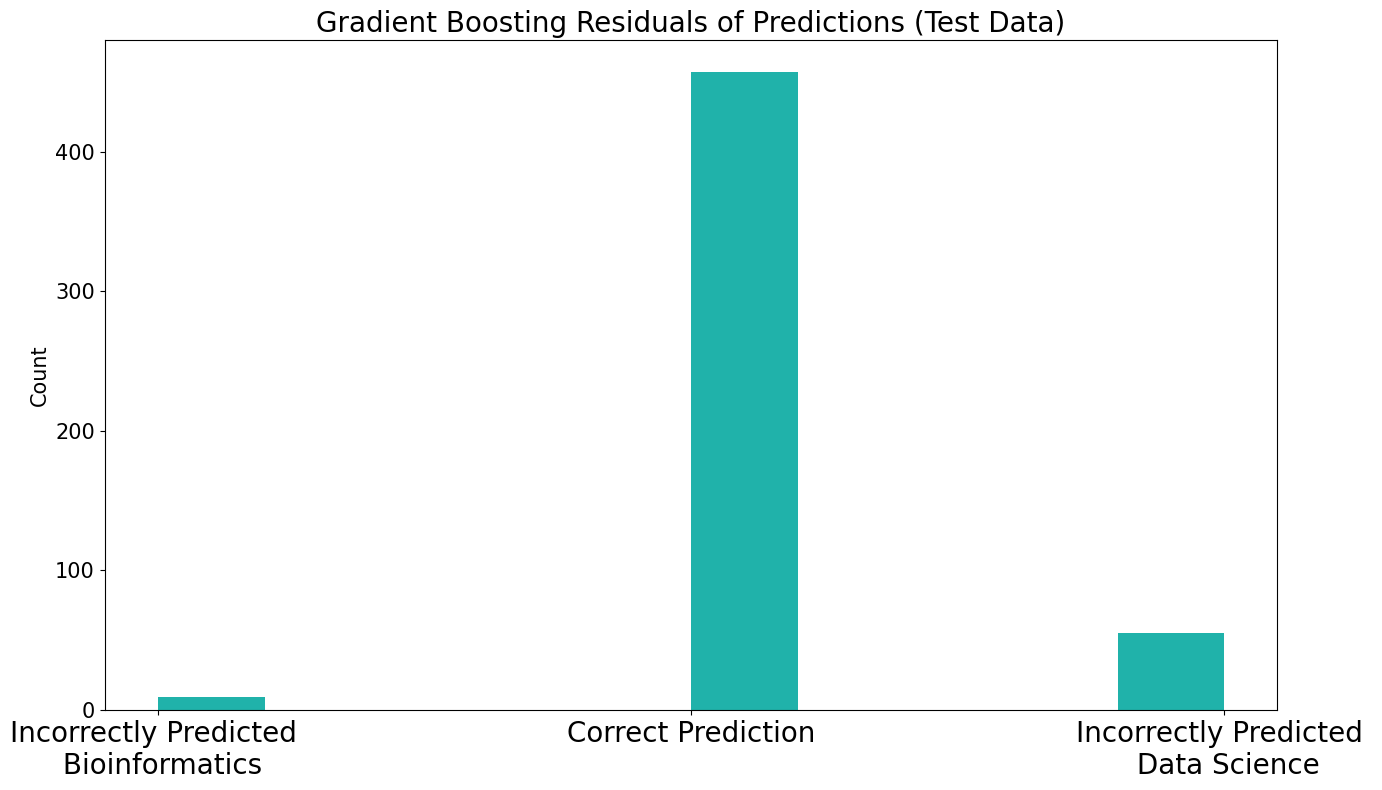

In [11]:
# Plot the resuduals of the mest model for this notebook
functions_for_modeling.plot_residuals(t_stem_gb, X_test, y_test, 'Gradient Boosting', 'gb_residuals')

The Gradient Boosting model has even more errors in predicting Biostatistics. It predicts the prevailing class even more often than Naive Bayes.

---

I have several strong models for XGBoost and Gradient Boosting Classifiers. Scores were better with Count Vectorizer for all my models, I will use only it for Stacking. However, the best parameters for Count Vectorizer are different, so I will need to search best parameters for Stacking. My best scores for models in this notebook are lower than my best Naive Bayes but close to it. I will try all three models together in the Stacking model in the next notebook. Tokenizers work differently on these models. I will try Stacking without Tokenization - which worked better for Naive Bayes, with Tokenizer with Stemming - which worked better for Gradient Boosting and XGBoost.